In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
eng_stopwords = set(stopwords.words('english'))
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [30]:
import jieba
jieba.load_userdict('user_dict.txt')
from snownlp import SnowNLP

In [31]:
train_df=pd.read_csv('atec_nlp_sim_train.csv',sep='\t',header=None,names=['id','q1','q2','label'],encoding='utf-8')

In [32]:
train_df.head(5)

,id,q1,q2,label
0,1,﻿怎么更改花呗手机号码,我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号,1
1,2,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0
2,3,花呗冻结以后还能开通吗,我的条件可以开通花呗借款吗,0
3,4,如何得知关闭借呗,想永久关闭借呗,0
4,5,花呗扫码付钱,二维码扫描可以用花呗吗,0


In [33]:
print(train_df.shape)

(39346, 4)


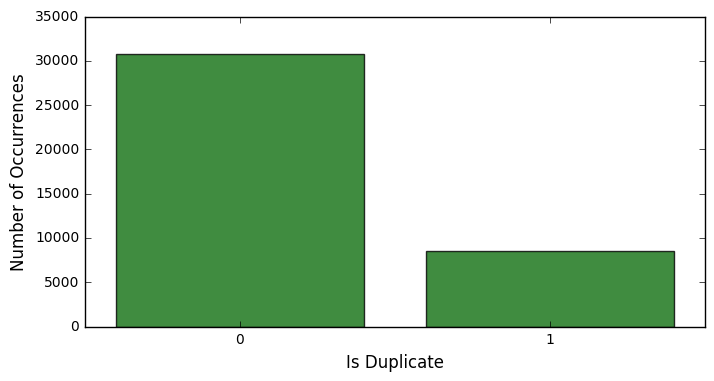

In [34]:
# Target Variable Exploration:

# First let us look at the target variable distribution.
# 先看看标签分布
is_dup = train_df['label'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.show()

In [35]:
is_dup / is_dup.sum()

0    0.782723
1    0.217277
Name: label, dtype: float64

In [36]:
# 78%的0标签
# 22%的1标签

#给每个句子进行分词
train_df['q1_words']=train_df['q1'].apply(lambda x:' '.join(jieba.lcut(x)))
train_df['q2_words']=train_df['q2'].apply(lambda x:' '.join(jieba.lcut(x)))

In [37]:
train_df.head(5)

,id,q1,q2,label,q1_words,q2_words
0,1,﻿怎么更改花呗手机号码,我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号,1,﻿ 怎么 更改 花呗 手机号码,我的 花呗 是 以前 的 手机号码 ， 怎么 更 改成 现在 的 支付宝 的 号码 手机号
1,2,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0,也 开 不了 花呗 ， 就 这样 了 ？ 完事 了,真的 嘛 ？ 就是 花呗 付款
2,3,花呗冻结以后还能开通吗,我的条件可以开通花呗借款吗,0,花呗 冻结 以后 还 能 开通 吗,我的 条件 可以 开通 花呗 借款 吗
3,4,如何得知关闭借呗,想永久关闭借呗,0,如何 得知 关闭 借呗,想 永久 关闭 借呗
4,5,花呗扫码付钱,二维码扫描可以用花呗吗,0,花呗 扫码 付钱,二维码 扫描 可以 用 花呗 吗


In [45]:
SnowNLP(train_df['q1'][2]).keywords()

['开通', '还', '冻结', '花']

In [46]:
SnowNLP(train_df['q2'][2]).keywords()

['开通', '条件', '花', '借款']

In [48]:
#给每个句子进行关键词的提取
train_df['q1_keywords']=train_df['q1'].apply(lambda x: SnowNLP(x).keywords())
train_df['q2_keywords']=train_df['q2'].apply(lambda x: SnowNLP(x).keywords())

In [49]:
train_df.head(3)

,id,q1,q2,label,q1_words,q2_words,q1_keywords,q2_keywords
0,1,﻿怎么更改花呗手机号码,我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号,1,﻿ 怎么 更改 花呗 手机号码,我的 花呗 是 以前 的 手机号码 ， 怎么 更 改成 现在 的 支付宝 的 号码 手机号,"[更, 手机, 改, 花, 号码]","[号码, 支付, 宝, 手机, 成]"
1,2,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0,也 开 不了 花呗 ， 就 这样 了 ？ 完事 了,真的 嘛 ？ 就是 花呗 付款,"[开, 花, 不]","[花, 呗付款]"
2,3,花呗冻结以后还能开通吗,我的条件可以开通花呗借款吗,0,花呗 冻结 以后 还 能 开通 吗,我的 条件 可以 开通 花呗 借款 吗,"[开通, 还, 冻结, 花]","[开通, 条件, 花, 借款]"


In [50]:
#计算每个句子的情感分析值，并计算两个句子的情感差异绝对值
S1=train_df['q1'].apply(lambda x : SnowNLP(x).sentiments)
S2=train_df['q2'].apply(lambda x : SnowNLP(x).sentiments)


In [52]:
train_df['sentiment1']=S1
train_df['sentiment2']=S2

In [53]:
train_df.head(3)

,id,q1,q2,label,q1_words,q2_words,q1_keywords,q2_keywords,sentiment1,sentiment2
0,1,﻿怎么更改花呗手机号码,我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号,1,﻿ 怎么 更改 花呗 手机号码,我的 花呗 是 以前 的 手机号码 ， 怎么 更 改成 现在 的 支付宝 的 号码 手机号,"[更, 手机, 改, 花, 号码]","[号码, 支付, 宝, 手机, 成]",0.204730,0.020891
1,2,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0,也 开 不了 花呗 ， 就 这样 了 ？ 完事 了,真的 嘛 ？ 就是 花呗 付款,"[开, 花, 不]","[花, 呗付款]",0.042884,0.456133
2,3,花呗冻结以后还能开通吗,我的条件可以开通花呗借款吗,0,花呗 冻结 以后 还 能 开通 吗,我的 条件 可以 开通 花呗 借款 吗,"[开通, 还, 冻结, 花]","[开通, 条件, 花, 借款]",0.096660,0.190250


In [54]:
train_df['sentiments_difference']=abs(S1-S2)

In [55]:
train_df.head(3)

,id,q1,q2,label,q1_words,q2_words,q1_keywords,q2_keywords,sentiment1,sentiment2,sentiments_difference
0,1,﻿怎么更改花呗手机号码,我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号,1,﻿ 怎么 更改 花呗 手机号码,我的 花呗 是 以前 的 手机号码 ， 怎么 更 改成 现在 的 支付宝 的 号码 手机号,"[更, 手机, 改, 花, 号码]","[号码, 支付, 宝, 手机, 成]",0.204730,0.020891,0.183839
1,2,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0,也 开 不了 花呗 ， 就 这样 了 ？ 完事 了,真的 嘛 ？ 就是 花呗 付款,"[开, 花, 不]","[花, 呗付款]",0.042884,0.456133,0.413248
2,3,花呗冻结以后还能开通吗,我的条件可以开通花呗借款吗,0,花呗 冻结 以后 还 能 开通 吗,我的 条件 可以 开通 花呗 借款 吗,"[开通, 还, 冻结, 花]","[开通, 条件, 花, 借款]",0.096660,0.190250,0.093590


In [62]:
#下面从数据集构造的角度，挖掘一些magic特征
#https://www.kaggle.com/sudalairajkumar/simple-leaky-exploration-notebook-quora?scriptVersionId=1184830
ques=train_df[['q1_words','q2_words']]

In [63]:
ques.shape

(39346, 2)

In [64]:
ques.head(3)

,q1_words,q2_words
0,﻿ 怎么 更改 花呗 手机号码,我的 花呗 是 以前 的 手机号码 ， 怎么 更 改成 现在 的 支付宝 的 号码 手机号
1,也 开 不了 花呗 ， 就 这样 了 ？ 完事 了,真的 嘛 ？ 就是 花呗 付款
2,花呗 冻结 以后 还 能 开通 吗,我的 条件 可以 开通 花呗 借款 吗


In [65]:
from collections import defaultdict
q_dict = defaultdict(set)
for i in range(ques.shape[0]):
        q_dict[ques.q1_words[i]].add(ques.q2_words[i])
        q_dict[ques.q2_words[i]].add(ques.q1_words[i])
        #这样q_dict里面就存在这样的键值对，q1:q2  / q2:q1

In [66]:
def q1_freq(row):
    return(len(q_dict[row['q1_words']]))
    
def q2_freq(row):
    return(len(q_dict[row['q2_words']]))
    
def q1_q2_intersect(row):
    return(len(set(q_dict[row['q1_words']]).intersection(set(q_dict[row['q2_words']]))))
    #这个特征是表示：在数据集中，当两个问题同时与k个问题比较是否是同意，此时返回k
    

train_df['q1_q2_intersect'] = train_df.apply(q1_q2_intersect, axis=1, raw=True)
train_df['q1_freq'] = train_df.apply(q1_freq, axis=1, raw=True)
train_df['q2_freq'] = train_df.apply(q2_freq, axis=1, raw=True)

In [101]:
train_df.head(3)

,id,q1,q2,label,q1_words,q2_words,q1_keywords,q2_keywords,sentiment1,sentiment2,sentiments_difference,q1_q2_intersect,q1_freq,q2_freq
0,1,﻿怎么更改花呗手机号码,我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号,1,﻿ 怎么 更改 花呗 手机号码,我的 花呗 是 以前 的 手机号码 ， 怎么 更 改成 现在 的 支付宝 的 号码 手机号,"[更, 手机, 改, 花, 号码]","[号码, 支付, 宝, 手机, 成]",0.204730,0.020891,0.183839,0,1,1
1,2,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0,也 开 不了 花呗 ， 就 这样 了 ？ 完事 了,真的 嘛 ？ 就是 花呗 付款,"[开, 花, 不]","[花, 呗付款]",0.042884,0.456133,0.413248,0,1,1
2,3,花呗冻结以后还能开通吗,我的条件可以开通花呗借款吗,0,花呗 冻结 以后 还 能 开通 吗,我的 条件 可以 开通 花呗 借款 吗,"[开通, 还, 冻结, 花]","[开通, 条件, 花, 借款]",0.096660,0.190250,0.093590,0,1,1


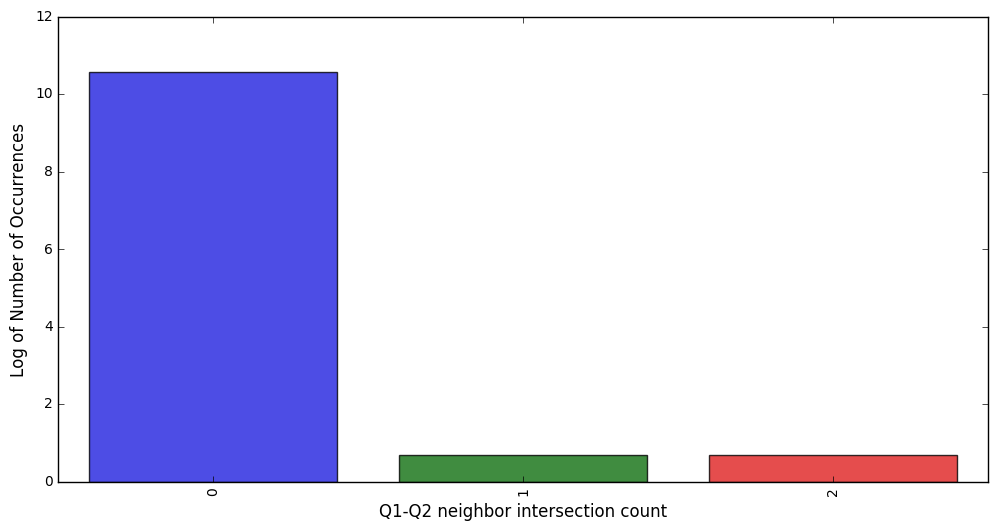

In [68]:
# Q1-Q2 neighbor intersection count:

# Let us first do simple count plots and see the distribution.

cnt_srs = train_df['q1_q2_intersect'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, np.log1p(cnt_srs.values), alpha=0.8)
plt.xlabel('Q1-Q2 neighbor intersection count', fontsize=12)
plt.ylabel('Log of Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

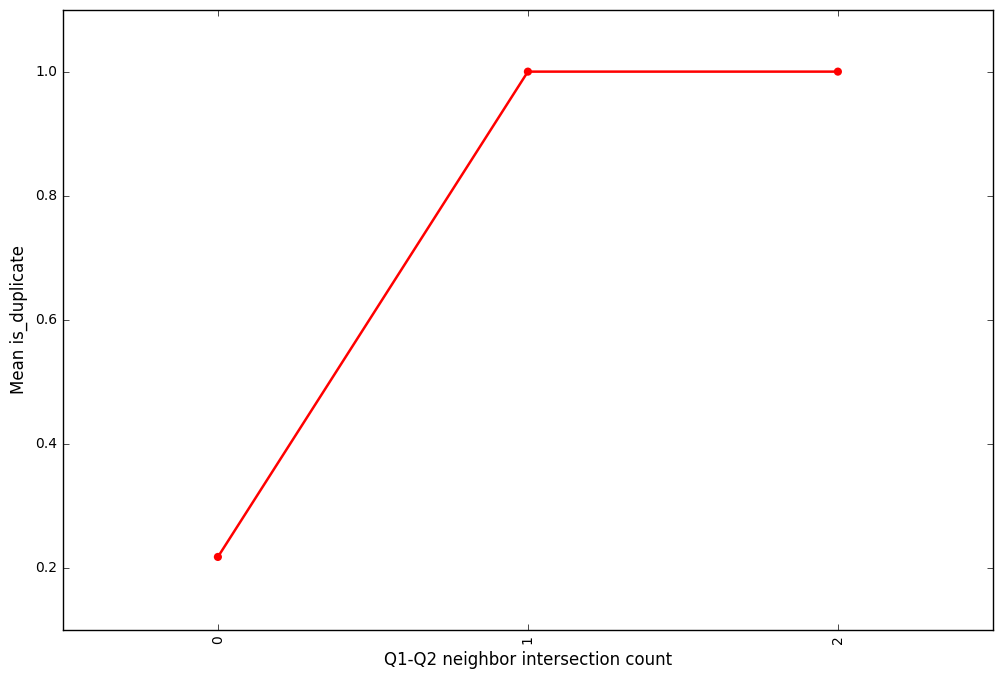

In [69]:
grouped_df = train_df.groupby('q1_q2_intersect')['label'].aggregate(np.mean).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df["q1_q2_intersect"].values, grouped_df["label"].values, alpha=0.8, color=color[2])
plt.ylabel('Mean is_duplicate', fontsize=12)
plt.xlabel('Q1-Q2 neighbor intersection count', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()


#下图基本说明这个特征在1或者2的时候，两个句子基本是同义的

In [70]:
q_dict

defaultdict(set,
            {'花呗 分期 最低 还 多少': {'花呗 多少 才能 分期 还款'},
             '为什么 退款 成功 了 花呗 还款额度 没 变': {'为什么 我的 花呗 还款额度 有 问题'},
             '取消 花呗 了 吗': {'我 都 取消 花呗 干嘛 还要 用'},
             '蚂蚁借呗   我 提前 还了 ， 明天 还 需要 还 吗': {'借呗 能 提前 还款 吗 ， 你'},
             '我 花呗 绑定 银行卡 为什么 用不了': {'为何 绑定 了 银行卡 之后 还是 还是 不能 用 花呗 ， 并且 还是 提示 让 绑定 银行卡'},
             '之前 的 手机 注册 的 花呗 ， 换 了 号码 怎么办': {'换 了 手机号 为什么 借呗 不能 用'},
             '我 可以 使用 花呗 向 商家 付款 吗': {'用 手机 扫描 手机店 的 支付宝 付款 时 可以 使用 花呗 吗'},
             '分期 过 的 花呗 账单 是不是 不可以 再 分期 了': {'为何 我的 花呗 账单 不能 分期'},
             '花呗 账单 明细 删除 了 怎么 还原': {'花呗 账单 删 了 怎样才能 找 回来'},
             '我 支付 的 时候 没有 花呗 的 显示': {'手机 上 没有 显示 花呗'},
             '对 花呗 账单 存在 疑问': {'花呗 所 消耗 的 账单'},
             '花呗 还了 最低 还款 后': {'花呗 最低 还款 之后 ， 下个月 还 能 继续'},
             '商家 码   花呗 手续费': {'客户 用 花呗 ， 商家 手续费'},
             '借呗 出来 的 钱 在 卡上 还是 支付宝 里面': {'在 支付宝 里 找 本到 蚂蚁借呗 ， 是 怎么回事'},
             '之前 还 花呗 都 不用 发 验证码 到 以前 手机号 的 ， 这次 是 怎么回事': {'我 这个 支付宝 号 用 的 借呗 ， 我 现在 想 还款 。 但是 我 手机

In [74]:
set(q_dict[train_df.iloc[3]['q1_words']])

{'想 永久 关闭 借呗'}

In [75]:
len(set(q_dict[train_df.iloc[3]['q1_words']]))

1

In [76]:
(len(set(q_dict[train_df.iloc[3]['q1_words']]).intersection(set(q_dict[train_df.iloc[3]['q2_words']]))))

0

In [77]:
(set(q_dict[train_df.iloc[3]['q1_words']]).intersection(set(q_dict[train_df.iloc[3]['q2_words']])))

set()

In [98]:
print(train_df[train_df['q1_q2_intersect']==2].index.tolist)

<bound method Index.tolist of Int64Index([17401], dtype='int64')>


In [96]:
print(train_df[train_df['q1_q2_intersect']==1].index.tolist)

<bound method Index.tolist of Int64Index([10809], dtype='int64')>


In [85]:
train_df.iloc[17401]

id                                                                   17402
q1                       【花呗】你的支付宝******@qq.com花呗***月账单自动还款失败，***元未还，请登...
q2                       【花呗】你的支付宝******@qq.com花呗***月账单自动还款失败，***元未还，请登...
label                                                                    1
q1_words                 【 花呗 】 你的 支付宝 * * * * * * @ qq . com 花呗 * * * ...
q2_words                 【 花呗 】 你的 支付宝 * * * * * * @ qq . com 花呗 * * * ...
q1_keywords                                            [***, 花, 宝, 还款, 支付]
q2_keywords                                            [***, 花, 宝, 还款, 支付]
sentiment1                                                     0.000774958
sentiment2                                                     0.000774958
sentiments_difference                                                    0
q1_q2_intersect                                                          2
q1_freq                                                                  2
q2_freq                  

In [99]:
train_df.iloc[10809]

id                                                                   10810
q1                       【花呗】你的支付宝************花呗***月账单自动还款失败，***元未还，请登录...
q2                       【花呗】你的支付宝******@qq.com花呗***月账单自动还款失败，***元未还，请登...
label                                                                    1
q1_words                 【 花呗 】 你的 支付宝 * * * * * * * * * * * * 花呗 * * *...
q2_words                 【 花呗 】 你的 支付宝 * * * * * * @ qq . com 花呗 * * * ...
q1_keywords                                            [***, 花, 宝, 还款, 支付]
q2_keywords                                            [***, 花, 宝, 还款, 支付]
sentiment1                                                     0.000774958
sentiment2                                                     0.000774958
sentiments_difference                                                    0
q1_q2_intersect                                                          1
q1_freq                                                                  2
q2_freq                  

In [97]:
cnt_srs

0    39344
2        1
1        1
Name: q1_q2_intersect, dtype: int64

In [102]:
#交差为2的是17401
#交差为1的是10809
#其它都为0 
'''但是之所以这个特征可能重要，是因为在训练集中体现不出来，为1的和为2的两个都是正样本了，那么在数据量非常大的测试集中，应该能体现出这个特征的重要性，所以可以试试'''

'但是之所以这个特征可能重要，是因为在训练集中体现不出来，为1的和为2的两个都是正样本了，那么在数据量非常大的测试集中，应该能体现出这个特征的重要性，所以可以试试'

In [103]:
train_df.head(5)

,id,q1,q2,label,q1_words,q2_words,q1_keywords,q2_keywords,sentiment1,sentiment2,sentiments_difference,q1_q2_intersect,q1_freq,q2_freq
0,1,﻿怎么更改花呗手机号码,我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号,1,﻿ 怎么 更改 花呗 手机号码,我的 花呗 是 以前 的 手机号码 ， 怎么 更 改成 现在 的 支付宝 的 号码 手机号,"[更, 手机, 改, 花, 号码]","[号码, 支付, 宝, 手机, 成]",0.204730,0.020891,0.183839,0,1,1
1,2,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0,也 开 不了 花呗 ， 就 这样 了 ？ 完事 了,真的 嘛 ？ 就是 花呗 付款,"[开, 花, 不]","[花, 呗付款]",0.042884,0.456133,0.413248,0,1,1
2,3,花呗冻结以后还能开通吗,我的条件可以开通花呗借款吗,0,花呗 冻结 以后 还 能 开通 吗,我的 条件 可以 开通 花呗 借款 吗,"[开通, 还, 冻结, 花]","[开通, 条件, 花, 借款]",0.096660,0.190250,0.093590,0,1,1
3,4,如何得知关闭借呗,想永久关闭借呗,0,如何 得知 关闭 借呗,想 永久 关闭 借呗,"[关闭, 得知, 借]","[关闭, 想, 借, 永久]",0.382171,0.865662,0.483492,0,1,1
4,5,花呗扫码付钱,二维码扫描可以用花呗吗,0,花呗 扫码 付钱,二维码 扫描 可以 用 花呗 吗,"[钱, 付, 扫码, 花]","[维码, 二, 扫描, 花]",0.073840,0.851221,0.777382,0,1,1


In [105]:
train_df['three_stars_count1']=train_df['q1'].apply(lambda x : x.count('*'*3))

In [106]:
train_df['three_stars_count2']=train_df['q2'].apply(lambda x : x.count('*'*3))

In [107]:
train_df.head(3)

,id,q1,q2,label,q1_words,q2_words,q1_keywords,q2_keywords,sentiment1,sentiment2,sentiments_difference,q1_q2_intersect,q1_freq,q2_freq,three_stars_count1,three_stars_count2
0,1,﻿怎么更改花呗手机号码,我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号,1,﻿ 怎么 更改 花呗 手机号码,我的 花呗 是 以前 的 手机号码 ， 怎么 更 改成 现在 的 支付宝 的 号码 手机号,"[更, 手机, 改, 花, 号码]","[号码, 支付, 宝, 手机, 成]",0.204730,0.020891,0.183839,0,1,1,0,0
1,2,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0,也 开 不了 花呗 ， 就 这样 了 ？ 完事 了,真的 嘛 ？ 就是 花呗 付款,"[开, 花, 不]","[花, 呗付款]",0.042884,0.456133,0.413248,0,1,1,0,0
2,3,花呗冻结以后还能开通吗,我的条件可以开通花呗借款吗,0,花呗 冻结 以后 还 能 开通 吗,我的 条件 可以 开通 花呗 借款 吗,"[开通, 还, 冻结, 花]","[开通, 条件, 花, 借款]",0.096660,0.190250,0.093590,0,1,1,0,0


In [111]:
# corrmat=train.corr()        #先获得数据的相关性矩阵
# plt.subplots(figsize=(15,12))
# sns.heatmap(corrmat,vmax=0.9,square=True)
train_df.columns

Index(['id', 'q1', 'q2', 'label', 'q1_words', 'q2_words', 'q1_keywords',
       'q2_keywords', 'sentiment1', 'sentiment2', 'sentiments_difference',
       'q1_q2_intersect', 'q1_freq', 'q2_freq', 'three_stars_count1',
       'three_stars_count2'],
      dtype='object')

In [114]:
num_attr= ['sentiment1', 'sentiment2', 'sentiments_difference','q1_q2_intersect', 'q1_freq', 'q2_freq', 'three_stars_count1', 'three_stars_count2','label']
sub_train=train_df[num_attr]

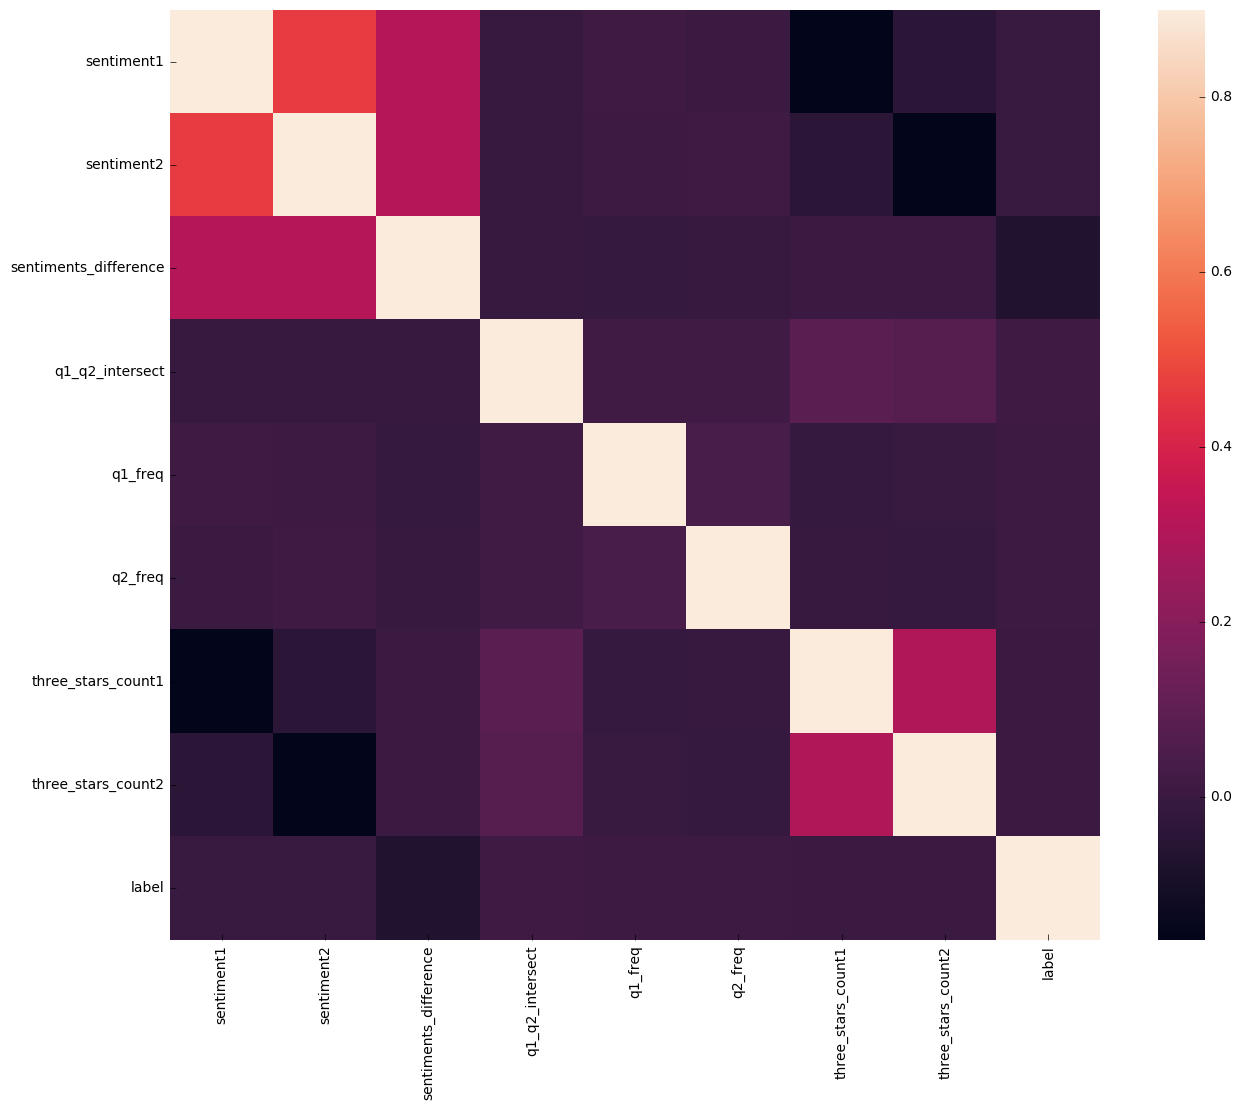

In [115]:
corrmat=sub_train.corr()        #先获得数据的相关性矩阵
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat,vmax=0.9,square=True)

In [117]:
from fuzzywuzzy import fuzz
def fuzzywuzzy_feature(raw_input_string_x1, raw_input_string_x2):
    '''
    :param input_string_x1:raw text or token type
    :param input_string_x2:raw text or token type
    :return:
    '''
    SimpleRatio=fuzz.ratio(raw_input_string_x1,raw_input_string_x2)
    PartialRatio=fuzz.partial_ratio(raw_input_string_x1,raw_input_string_x2)

    #计算token的fuzzywuzzy
    x1_word_string=' '.join(jieba.lcut(raw_input_string_x1))
    x2_word_string=' '.join(jieba.lcut(raw_input_string_x2))
    #print(x1_word_string,x2_word_string)
    #TokenSortRatio=fuzz.token_sort_ratio(raw_input_string_x1,raw_input_string_x2)
    #TokenSetRatio=fuzz.token_set_ratio(raw_input_string_x1,raw_input_string_x2)
    SimpleRatio_word = fuzz.ratio(x1_word_string, x2_word_string)
    PartialRatio_word= fuzz.partial_ratio(x1_word_string, x2_word_string)

    return [SimpleRatio,PartialRatio,SimpleRatio_word,PartialRatio_word]

fuzzywuzzy=train_df.apply(lambda row: fuzzywuzzy_feature(row['q1'],row['q2']),axis=1)

D:\Python相关\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [122]:
train_df['fuzzywuzzy']=fuzzywuzzy

In [125]:
train_df.head(3)

,id,q1,q2,label,q1_words,q2_words,q1_keywords,q2_keywords,sentiment1,sentiment2,sentiments_difference,q1_q2_intersect,q1_freq,q2_freq,three_stars_count1,three_stars_count2,fuzzywuzzy
0,1,﻿怎么更改花呗手机号码,我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号,1,﻿ 怎么 更改 花呗 手机号码,我的 花呗 是 以前 的 手机号码 ， 怎么 更 改成 现在 的 支付宝 的 号码 手机号,"[更, 手机, 改, 花, 号码]","[号码, 支付, 宝, 手机, 成]",0.204730,0.020891,0.183839,0,1,1,0,0,"[34, 36, 37, 53]"
1,2,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0,也 开 不了 花呗 ， 就 这样 了 ？ 完事 了,真的 嘛 ？ 就是 花呗 付款,"[开, 花, 不]","[花, 呗付款]",0.042884,0.456133,0.413248,0,1,1,0,0,"[16, 20, 30, 40]"
2,3,花呗冻结以后还能开通吗,我的条件可以开通花呗借款吗,0,花呗 冻结 以后 还 能 开通 吗,我的 条件 可以 开通 花呗 借款 吗,"[开通, 还, 冻结, 花]","[开通, 条件, 花, 借款]",0.096660,0.190250,0.093590,0,1,1,0,0,"[25, 38, 44, 47]"


In [126]:
train_df['SimpleRatio']=train_df.apply(lambda row: row['fuzzywuzzy'][0],axis=1)

In [127]:
# SimpleRatio,PartialRatio,SimpleRatio_word,PartialRatio_word
train_df['PartialRatio']=train_df.apply(lambda row: row['fuzzywuzzy'][1],axis=1)
train_df['SimpleRatio_word']=train_df.apply(lambda row: row['fuzzywuzzy'][2],axis=1)
train_df['PartialRatio_word']=train_df.apply(lambda row: row['fuzzywuzzy'][3],axis=1)

In [129]:
train_df.columns[8:]

Index(['sentiment1', 'sentiment2', 'sentiments_difference', 'q1_q2_intersect',
       'q1_freq', 'q2_freq', 'three_stars_count1', 'three_stars_count2',
       'fuzzywuzzy', 'SimpleRatio', 'PartialRatio', 'SimpleRatio_word',
       'PartialRatio_word'],
      dtype='object')

In [142]:
sub_attr=['sentiment1', 'sentiment2', 'sentiments_difference', 'q1_q2_intersect',
       'q1_freq', 'q2_freq', 'three_stars_count1', 'three_stars_count2',
       'fuzzywuzzy', 'SimpleRatio', 'PartialRatio', 'SimpleRatio_word',
       'PartialRatio_word','label']

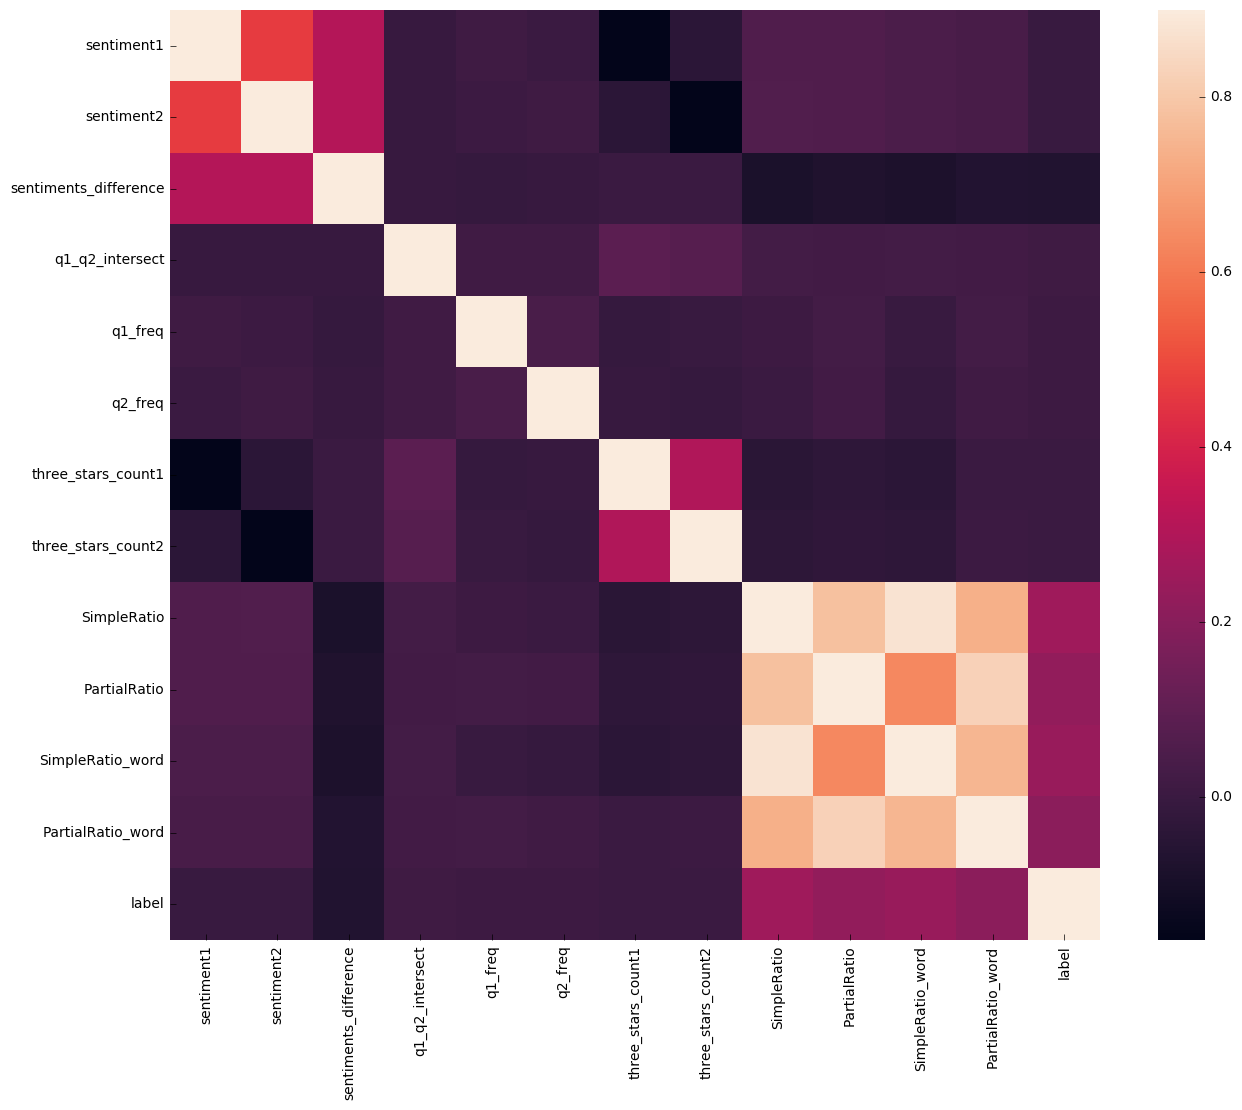

In [143]:
sub_attr_train=train_df[sub_attr]
corrmat=sub_attr_train.corr()        #先获得数据的相关性矩阵
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat,vmax=0.9,square=True)

In [144]:
corrmat

,sentiment1,sentiment2,sentiments_difference,q1_q2_intersect,q1_freq,q2_freq,three_stars_count1,three_stars_count2,SimpleRatio,PartialRatio,SimpleRatio_word,PartialRatio_word,label
sentiment1,1.000000,0.466579,0.308075,-0.007746,0.015007,0.002380,-0.162654,-0.039004,0.060093,0.059024,0.047888,0.037388,-0.003278
sentiment2,0.466579,1.000000,0.309140,-0.007713,0.005201,0.015000,-0.040113,-0.162959,0.065300,0.060097,0.048064,0.038938,-0.003936
sentiments_difference,0.308075,0.309140,1.000000,-0.007295,-0.012899,-0.006071,-0.000653,-0.000396,-0.086415,-0.075361,-0.082418,-0.065508,-0.071475
q1_q2_intersect,-0.007746,-0.007713,-0.007295,1.000000,0.019189,0.018107,0.088825,0.076937,0.025489,0.022571,0.024712,0.022869,0.012838
q1_freq,0.015007,0.005201,-0.012899,0.019189,1.000000,0.041660,-0.013173,-0.001444,0.008586,0.024042,-0.002471,0.024570,0.010832
q2_freq,0.002380,0.015000,-0.006071,0.018107,0.041660,1.000000,-0.006291,-0.011784,0.001263,0.021170,-0.010709,0.017532,0.007443
three_stars_count1,-0.162654,-0.040113,-0.000653,0.088825,-0.013173,-0.006291,1.000000,0.301774,-0.043317,-0.032199,-0.042449,0.001835,0.001305
three_stars_count2,-0.039004,-0.162959,-0.000396,0.076937,-0.001444,-0.011784,0.301774,1.000000,-0.034620,-0.029247,-0.032620,0.006524,0.002276
SimpleRatio,0.060093,0.065300,-0.086415,0.025489,0.008586,0.001263,-0.043317,-0.034620,1.000000,0.782622,0.878329,0.735020,0.260193
PartialRatio,0.059024,0.060097,-0.075361,0.022571,0.024042,0.021170,-0.032199,-0.029247,0.782622,1.000000,0.634779,0.827537,0.225961


In [133]:
import gensim

D:\Python相关\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [134]:
model = gensim.models.KeyedVectors.load_word2vec_format('word2vec.txt', binary=False)

In [136]:
stop_words=['的',',','。']
def wmd(s1, s2):
    s1 = s1.split()
    s2 = s2.split()
    # stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)

In [137]:
train_df.head(5)

,id,q1,q2,label,q1_words,q2_words,q1_keywords,q2_keywords,sentiment1,sentiment2,...,q1_q2_intersect,q1_freq,q2_freq,three_stars_count1,three_stars_count2,fuzzywuzzy,SimpleRatio,PartialRatio,SimpleRatio_word,PartialRatio_word
0,1,﻿怎么更改花呗手机号码,我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号,1,﻿ 怎么 更改 花呗 手机号码,我的 花呗 是 以前 的 手机号码 ， 怎么 更 改成 现在 的 支付宝 的 号码 手机号,"[更, 手机, 改, 花, 号码]","[号码, 支付, 宝, 手机, 成]",0.204730,0.020891,...,0,1,1,0,0,"[34, 36, 37, 53]",34,36,37,53
1,2,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0,也 开 不了 花呗 ， 就 这样 了 ？ 完事 了,真的 嘛 ？ 就是 花呗 付款,"[开, 花, 不]","[花, 呗付款]",0.042884,0.456133,...,0,1,1,0,0,"[16, 20, 30, 40]",16,20,30,40
2,3,花呗冻结以后还能开通吗,我的条件可以开通花呗借款吗,0,花呗 冻结 以后 还 能 开通 吗,我的 条件 可以 开通 花呗 借款 吗,"[开通, 还, 冻结, 花]","[开通, 条件, 花, 借款]",0.096660,0.190250,...,0,1,1,0,0,"[25, 38, 44, 47]",25,38,44,47
3,4,如何得知关闭借呗,想永久关闭借呗,0,如何 得知 关闭 借呗,想 永久 关闭 借呗,"[关闭, 得知, 借]","[关闭, 想, 借, 永久]",0.382171,0.865662,...,0,1,1,0,0,"[53, 57, 67, 70]",53,57,67,70
4,5,花呗扫码付钱,二维码扫描可以用花呗吗,0,花呗 扫码 付钱,二维码 扫描 可以 用 花呗 吗,"[钱, 付, 扫码, 花]","[维码, 二, 扫描, 花]",0.073840,0.851221,...,0,1,1,0,0,"[24, 44, 25, 50]",24,44,25,50


In [139]:
# model['蚂蚁花呗']没有蚂蚁花呗这个词

KeyError: "word '蚂蚁花呗' not in vocabulary"

In [140]:
train_df['wmd'] = train_df.apply(lambda x: wmd(x['q1_words'], x['q2_words']), axis=1)

ImportError: Please install pyemd Python package to compute WMD.